In [ ]:
import os

# Import installed libraries
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/path name/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))


In [ ]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [ ]:
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1, 1)).toarray()
asteroids_oh_y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
oh_init = [1, 0, 0, 0]
for n in range(4):
   oh_class = oh_init[-n:] + oh_init[:-n]
   org_class = label_encoder.inverse_transform([oh_class])
   print(f"One-Hot: {oh_class} corresponds to the class {org_class[0][0]}")


One-Hot: [1, 0, 0, 0] corresponds to the class C
One-Hot: [0, 1, 0, 0] corresponds to the class Other
One-Hot: [0, 0, 1, 0] corresponds to the class S
One-Hot: [0, 0, 0, 1] corresponds to the class X


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import tensorflow.keras as keras

n_inputs = asteroids_X.shape[1]

def create_model():

    # Normalizsation layer (like the scikit-learn StandardScaler)
    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs,))

    hidden_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Dense(25)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    hidden_layer = keras.layers.Dense(10)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

end_epoch = 500
batch_size = 32

history =model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    sample_weight=sample_weight)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 49)]              0         
                                                                 
 normalization_3 (Normaliza  (None, 49)                99        
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 25)                1250      
                                                                 
 re_lu_4 (ReLU)              (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                260       
                                                                 
 re_lu_5 (ReLU)              (None, 10)                0         
                                                           

25/25 [==============================] - 1s 11ms/step - loss: 0.6101 - val_loss: 0.5119
Epoch 2/500
21/25 [========================>.....] - ETA: 0s - loss: 0.4538

25/25 [==============================] - 0s 5ms/step - loss: 0.4422 - val_loss: 0.4247
Epoch 3/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3519

25/25 [==============================] - 0s 4ms/step - loss: 0.3669 - val_loss: 0.3698
Epoch 4/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3582

25/25 [==============================] - 0s 4ms/step - loss: 0.3190 - val_loss: 0.3330
Epoch 5/500
24/25 [===========================>..] - ETA: 0s - loss: 0.2815

25/25 [==============================] - 0s 4ms/step - loss: 0.2880 - val_loss: 0.3185
Epoch 6/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3219

25/25 [==============================] - 0s 3ms/step - loss: 0.2726 - val_loss: 0.3033
Epoch 7/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1716

25/25 [==============================] - 0s 3ms/step - loss: 0.2552 - val_loss: 0.2977
Epoch 8/500
25/25 [==============================] - ETA: 0s - loss: 0.2437

25/25 [==============================] - 0s 7ms/step - loss: 0.2437 - val_loss: 0.2883
Epoch 9/500
23/25 [==========================>...] - ETA: 0s - loss: 0.2342

25/25 [==============================] - 0s 4ms/step - loss: 0.2345 - val_loss: 0.2844
Epoch 10/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3455

25/25 [==============================] - 0s 4ms/step - loss: 0.2281 - val_loss: 0.2761
Epoch 11/500
24/25 [===========================>..] - ETA: 0s - loss: 0.2137

25/25 [==============================] - 0s 4ms/step - loss: 0.2161 - val_loss: 0.2729
Epoch 12/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3008

25/25 [==============================] - 0s 4ms/step - loss: 0.2087 - val_loss: 0.2756
Epoch 13/500
 1/25 [>.............................] - ETA: 0s - loss: 0.2751

25/25 [==============================] - 0s 4ms/step - loss: 0.2054 - val_loss: 0.2653
Epoch 14/500
16/25 [==================>...........] - ETA: 0s - loss: 0.1930

25/25 [==============================] - 0s 5ms/step - loss: 0.1990 - val_loss: 0.2594
Epoch 15/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1377

25/25 [==============================] - 0s 4ms/step - loss: 0.1929 - val_loss: 0.2549
Epoch 16/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1358

25/25 [==============================] - 0s 4ms/step - loss: 0.1828 - val_loss: 0.2565
Epoch 17/500
25/25 [==============================] - ETA: 0s - loss: 0.1808

25/25 [==============================] - 0s 4ms/step - loss: 0.1808 - val_loss: 0.2523
Epoch 18/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1949

25/25 [==============================] - 0s 4ms/step - loss: 0.1783 - val_loss: 0.2454
Epoch 19/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1405

25/25 [==============================] - 0s 4ms/step - loss: 0.1717 - val_loss: 0.2418
Epoch 20/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1963

25/25 [==============================] - 0s 4ms/step - loss: 0.1658 - val_loss: 0.2378
Epoch 21/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0552

25/25 [==============================] - 0s 4ms/step - loss: 0.1616 - val_loss: 0.2379
Epoch 22/500
25/25 [==============================] - ETA: 0s - loss: 0.1565

25/25 [==============================] - 0s 5ms/step - loss: 0.1565 - val_loss: 0.2383
Epoch 23/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1573

25/25 [==============================] - 0s 5ms/step - loss: 0.1575 - val_loss: 0.2279
Epoch 24/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1593

25/25 [==============================] - 0s 4ms/step - loss: 0.1526 - val_loss: 0.2279
Epoch 25/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1532

25/25 [==============================] - 0s 4ms/step - loss: 0.1467 - val_loss: 0.2193
Epoch 26/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1711

25/25 [==============================] - 0s 4ms/step - loss: 0.1431 - val_loss: 0.2295
Epoch 27/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1456

25/25 [==============================] - 0s 5ms/step - loss: 0.1461 - val_loss: 0.2188
Epoch 28/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1268

25/25 [==============================] - 0s 4ms/step - loss: 0.1400 - val_loss: 0.2136
Epoch 29/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1338

25/25 [==============================] - 0s 4ms/step - loss: 0.1326 - val_loss: 0.2060
Epoch 30/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1764

25/25 [==============================] - 0s 4ms/step - loss: 0.1335 - val_loss: 0.2047
Epoch 31/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1092

25/25 [==============================] - 0s 4ms/step - loss: 0.1273 - val_loss: 0.2110
Epoch 32/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0896

25/25 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.2075
Epoch 33/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0712

25/25 [==============================] - 0s 4ms/step - loss: 0.1228 - val_loss: 0.2021
Epoch 34/500
25/25 [==============================] - ETA: 0s - loss: 0.1199

25/25 [==============================] - 0s 4ms/step - loss: 0.1199 - val_loss: 0.2008
Epoch 35/500
25/25 [==============================] - ETA: 0s - loss: 0.1185

25/25 [==============================] - 0s 5ms/step - loss: 0.1185 - val_loss: 0.1923
Epoch 36/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1164

25/25 [==============================] - 0s 5ms/step - loss: 0.1136 - val_loss: 0.1972
Epoch 37/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1443

25/25 [==============================] - 0s 4ms/step - loss: 0.1157 - val_loss: 0.1893
Epoch 38/500
25/25 [==============================] - ETA: 0s - loss: 0.1123

25/25 [==============================] - 0s 4ms/step - loss: 0.1123 - val_loss: 0.1935
Epoch 39/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1052

25/25 [==============================] - 0s 5ms/step - loss: 0.1098 - val_loss: 0.1917
Epoch 40/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1515

25/25 [==============================] - 0s 4ms/step - loss: 0.1093 - val_loss: 0.1967
Epoch 41/500
18/25 [====================>.........] - ETA: 0s - loss: 0.1063

25/25 [==============================] - 0s 5ms/step - loss: 0.1061 - val_loss: 0.1852
Epoch 42/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1672

25/25 [==============================] - 0s 4ms/step - loss: 0.1057 - val_loss: 0.2034
Epoch 43/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0929

25/25 [==============================] - 0s 4ms/step - loss: 0.1031 - val_loss: 0.1893
Epoch 44/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1045

25/25 [==============================] - 0s 5ms/step - loss: 0.1008 - val_loss: 0.1913
Epoch 45/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0986

25/25 [==============================] - 0s 5ms/step - loss: 0.1005 - val_loss: 0.1824
Epoch 46/500
25/25 [==============================] - ETA: 0s - loss: 0.0984

25/25 [==============================] - 0s 4ms/step - loss: 0.0984 - val_loss: 0.1818
Epoch 47/500
25/25 [==============================] - ETA: 0s - loss: 0.0923

25/25 [==============================] - 0s 4ms/step - loss: 0.0923 - val_loss: 0.1768
Epoch 48/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0238

25/25 [==============================] - 0s 4ms/step - loss: 0.0960 - val_loss: 0.1799
Epoch 49/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0576

25/25 [==============================] - 0s 6ms/step - loss: 0.0947 - val_loss: 0.1793
Epoch 50/500
25/25 [==============================] - ETA: 0s - loss: 0.0908

25/25 [==============================] - 0s 5ms/step - loss: 0.0908 - val_loss: 0.1739
Epoch 51/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1222

25/25 [==============================] - 0s 4ms/step - loss: 0.0881 - val_loss: 0.2034
Epoch 52/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0941

25/25 [==============================] - 0s 5ms/step - loss: 0.0922 - val_loss: 0.1850
Epoch 53/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0614

25/25 [==============================] - 0s 4ms/step - loss: 0.0873 - val_loss: 0.1758
Epoch 54/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0501

25/25 [==============================] - 0s 4ms/step - loss: 0.0854 - val_loss: 0.1736
Epoch 55/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0772

25/25 [==============================] - 0s 4ms/step - loss: 0.0866 - val_loss: 0.1732
Epoch 56/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0860

25/25 [==============================] - 0s 5ms/step - loss: 0.0844 - val_loss: 0.1838
Epoch 57/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1149

25/25 [==============================] - 0s 4ms/step - loss: 0.0834 - val_loss: 0.1744
Epoch 58/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0843

25/25 [==============================] - 0s 5ms/step - loss: 0.0842 - val_loss: 0.1740
Epoch 59/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0561

25/25 [==============================] - 0s 4ms/step - loss: 0.0798 - val_loss: 0.1735
Epoch 60/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0836

25/25 [==============================] - 0s 4ms/step - loss: 0.0792 - val_loss: 0.1739
Epoch 61/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0802

25/25 [==============================] - 0s 5ms/step - loss: 0.0779 - val_loss: 0.1702
Epoch 62/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0714

25/25 [==============================] - 0s 7ms/step - loss: 0.0758 - val_loss: 0.1713
Epoch 63/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0723

25/25 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.1712
Epoch 64/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0736

25/25 [==============================] - 0s 5ms/step - loss: 0.0758 - val_loss: 0.1720
Epoch 65/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0725

25/25 [==============================] - 0s 8ms/step - loss: 0.0760 - val_loss: 0.1731
Epoch 66/500
25/25 [==============================] - ETA: 0s - loss: 0.0724

25/25 [==============================] - 0s 20ms/step - loss: 0.0724 - val_loss: 0.1695
Epoch 67/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0828

25/25 [==============================] - 0s 15ms/step - loss: 0.0720 - val_loss: 0.1726
Epoch 68/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0772

25/25 [==============================] - 1s 24ms/step - loss: 0.0754 - val_loss: 0.1700
Epoch 69/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0690

25/25 [==============================] - 0s 19ms/step - loss: 0.0693 - val_loss: 0.1753
Epoch 70/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0644

25/25 [==============================] - 0s 15ms/step - loss: 0.0709 - val_loss: 0.1719
Epoch 71/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0686

25/25 [==============================] - 0s 17ms/step - loss: 0.0686 - val_loss: 0.1662
Epoch 72/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0717

25/25 [==============================] - 1s 22ms/step - loss: 0.0713 - val_loss: 0.1640
Epoch 73/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0707

25/25 [==============================] - 0s 14ms/step - loss: 0.0686 - val_loss: 0.1656
Epoch 74/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0703

25/25 [==============================] - 0s 19ms/step - loss: 0.0670 - val_loss: 0.1696
Epoch 75/500
25/25 [==============================] - ETA: 0s - loss: 0.0650

25/25 [==============================] - 0s 13ms/step - loss: 0.0650 - val_loss: 0.1632
Epoch 76/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0657

25/25 [==============================] - 0s 6ms/step - loss: 0.0659 - val_loss: 0.1670
Epoch 77/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0564

25/25 [==============================] - 0s 4ms/step - loss: 0.0634 - val_loss: 0.1736
Epoch 78/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0474

25/25 [==============================] - 0s 4ms/step - loss: 0.0664 - val_loss: 0.1754
Epoch 79/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0382

25/25 [==============================] - 0s 4ms/step - loss: 0.0600 - val_loss: 0.1682
Epoch 80/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0342

25/25 [==============================] - 0s 4ms/step - loss: 0.0621 - val_loss: 0.1738
Epoch 81/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0242

25/25 [==============================] - 0s 4ms/step - loss: 0.0597 - val_loss: 0.1747
Epoch 82/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0142

25/25 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.1705
Epoch 83/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0358

25/25 [==============================] - 0s 4ms/step - loss: 0.0632 - val_loss: 0.1742
Epoch 84/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0544

25/25 [==============================] - 0s 5ms/step - loss: 0.0586 - val_loss: 0.1640
Epoch 85/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0435

25/25 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.1703
Epoch 86/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0920

25/25 [==============================] - 0s 4ms/step - loss: 0.0593 - val_loss: 0.1666
Epoch 87/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0602

25/25 [==============================] - 0s 5ms/step - loss: 0.0611 - val_loss: 0.1653
Epoch 88/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0589

25/25 [==============================] - 0s 4ms/step - loss: 0.0582 - val_loss: 0.1642
Epoch 89/500
25/25 [==============================] - ETA: 0s - loss: 0.0556

25/25 [==============================] - 0s 5ms/step - loss: 0.0556 - val_loss: 0.1893
Epoch 90/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0533

25/25 [==============================] - 0s 5ms/step - loss: 0.0547 - val_loss: 0.1653
Epoch 91/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0573

25/25 [==============================] - 0s 5ms/step - loss: 0.0554 - val_loss: 0.1667
Epoch 92/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0697

25/25 [==============================] - 0s 4ms/step - loss: 0.0554 - val_loss: 0.1647
Epoch 93/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0606

25/25 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.1635
Epoch 94/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0555

25/25 [==============================] - 0s 5ms/step - loss: 0.0553 - val_loss: 0.1771
Epoch 95/500
25/25 [==============================] - ETA: 0s - loss: 0.0527

25/25 [==============================] - 0s 5ms/step - loss: 0.0527 - val_loss: 0.1705
Epoch 96/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0331

25/25 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.1655
Epoch 97/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0793

25/25 [==============================] - 0s 4ms/step - loss: 0.0563 - val_loss: 0.1669
Epoch 98/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0516

25/25 [==============================] - 0s 5ms/step - loss: 0.0510 - val_loss: 0.1770
Epoch 99/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0557

25/25 [==============================] - 0s 5ms/step - loss: 0.0528 - val_loss: 0.1707
Epoch 100/500
25/25 [==============================] - ETA: 0s - loss: 0.0510

25/25 [==============================] - 0s 5ms/step - loss: 0.0510 - val_loss: 0.1859
Epoch 101/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0367

25/25 [==============================] - 0s 4ms/step - loss: 0.0521 - val_loss: 0.1737
Epoch 102/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0511

25/25 [==============================] - 0s 4ms/step - loss: 0.0530 - val_loss: 0.1717
Epoch 103/500
25/25 [==============================] - ETA: 0s - loss: 0.0498

25/25 [==============================] - 0s 4ms/step - loss: 0.0498 - val_loss: 0.1724
Epoch 104/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0622

25/25 [==============================] - 0s 4ms/step - loss: 0.0471 - val_loss: 0.1791
Epoch 105/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0542

25/25 [==============================] - 0s 4ms/step - loss: 0.0523 - val_loss: 0.1874
Epoch 106/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0473

25/25 [==============================] - 0s 5ms/step - loss: 0.0468 - val_loss: 0.1844
Epoch 107/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1296

25/25 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.2008
Epoch 108/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0467

25/25 [==============================] - 0s 5ms/step - loss: 0.0481 - val_loss: 0.1817
Epoch 109/500
25/25 [==============================] - ETA: 0s - loss: 0.0464

25/25 [==============================] - 0s 4ms/step - loss: 0.0464 - val_loss: 0.1783
Epoch 110/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0530

25/25 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.1714
Epoch 111/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1213

25/25 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.1797
Epoch 112/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0090

25/25 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.1709
Epoch 113/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0458

25/25 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.1685
Epoch 114/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0915

25/25 [==============================] - 0s 4ms/step - loss: 0.0450 - val_loss: 0.1700
Epoch 115/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0228

25/25 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.1722
Epoch 116/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0430

25/25 [==============================] - 0s 5ms/step - loss: 0.0443 - val_loss: 0.1762
Epoch 117/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0417

25/25 [==============================] - 0s 5ms/step - loss: 0.0418 - val_loss: 0.1905
Epoch 118/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0085

25/25 [==============================] - 0s 4ms/step - loss: 0.0464 - val_loss: 0.1797
Epoch 119/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0985

25/25 [==============================] - 0s 4ms/step - loss: 0.0419 - val_loss: 0.1746
Epoch 120/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0518

25/25 [==============================] - 0s 4ms/step - loss: 0.0439 - val_loss: 0.1802
Epoch 121/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0253

25/25 [==============================] - 0s 4ms/step - loss: 0.0445 - val_loss: 0.1780
Epoch 122/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0438

25/25 [==============================] - 0s 5ms/step - loss: 0.0426 - val_loss: 0.1709
Epoch 123/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0178

25/25 [==============================] - 0s 4ms/step - loss: 0.0438 - val_loss: 0.1766
Epoch 124/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0426

25/25 [==============================] - 0s 4ms/step - loss: 0.0406 - val_loss: 0.1749
Epoch 125/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0221

25/25 [==============================] - 0s 4ms/step - loss: 0.0417 - val_loss: 0.1740
Epoch 126/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0223

25/25 [==============================] - 0s 4ms/step - loss: 0.0425 - val_loss: 0.1737
Epoch 127/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0415

25/25 [==============================] - 0s 5ms/step - loss: 0.0392 - val_loss: 0.1811
Epoch 128/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1192

25/25 [==============================] - 0s 4ms/step - loss: 0.0406 - val_loss: 0.1852
Epoch 129/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0444

25/25 [==============================] - 0s 4ms/step - loss: 0.0435 - val_loss: 0.1803
Epoch 130/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0376

25/25 [==============================] - 0s 4ms/step - loss: 0.0410 - val_loss: 0.1813
Epoch 131/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0773

25/25 [==============================] - 0s 4ms/step - loss: 0.0411 - val_loss: 0.1737
Epoch 132/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0397

25/25 [==============================] - 0s 4ms/step - loss: 0.0404 - val_loss: 0.1848
Epoch 133/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0413

25/25 [==============================] - 0s 5ms/step - loss: 0.0390 - val_loss: 0.1870
Epoch 134/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0161

25/25 [==============================] - 0s 5ms/step - loss: 0.0428 - val_loss: 0.1746
Epoch 135/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0367

25/25 [==============================] - 0s 5ms/step - loss: 0.0382 - val_loss: 0.1806
Epoch 136/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0260

25/25 [==============================] - 0s 4ms/step - loss: 0.0390 - val_loss: 0.2038
Epoch 137/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0431

25/25 [==============================] - 0s 5ms/step - loss: 0.0397 - val_loss: 0.1850
Epoch 138/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0463

25/25 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.1934
Epoch 139/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0344

25/25 [==============================] - 0s 5ms/step - loss: 0.0352 - val_loss: 0.1913
Epoch 140/500
25/25 [==============================] - ETA: 0s - loss: 0.0399

25/25 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.1843
Epoch 141/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0329

25/25 [==============================] - 0s 4ms/step - loss: 0.0359 - val_loss: 0.1939
Epoch 142/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0546

25/25 [==============================] - 0s 6ms/step - loss: 0.0405 - val_loss: 0.1903
Epoch 143/500
 1/25 [>.............................] - ETA: 0s - loss: 0.1110

25/25 [==============================] - 0s 4ms/step - loss: 0.0358 - val_loss: 0.1853
Epoch 144/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0164

25/25 [==============================] - 0s 4ms/step - loss: 0.0388 - val_loss: 0.1836
Epoch 145/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0436

25/25 [==============================] - 0s 4ms/step - loss: 0.0365 - val_loss: 0.1861
Epoch 146/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0249

25/25 [==============================] - 0s 4ms/step - loss: 0.0374 - val_loss: 0.1842
Epoch 147/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0115

25/25 [==============================] - 0s 4ms/step - loss: 0.0367 - val_loss: 0.1811
Epoch 148/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0140

25/25 [==============================] - 0s 4ms/step - loss: 0.0363 - val_loss: 0.1830
Epoch 149/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0387

25/25 [==============================] - 0s 5ms/step - loss: 0.0369 - val_loss: 0.1852
Epoch 150/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0115

25/25 [==============================] - 0s 4ms/step - loss: 0.0360 - val_loss: 0.1833
Epoch 151/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0401

25/25 [==============================] - 0s 6ms/step - loss: 0.0367 - val_loss: 0.1836
Epoch 152/500
25/25 [==============================] - ETA: 0s - loss: 0.0352

25/25 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.1875
Epoch 153/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0097

25/25 [==============================] - 0s 4ms/step - loss: 0.0360 - val_loss: 0.1865
Epoch 154/500
25/25 [==============================] - ETA: 0s - loss: 0.0337

25/25 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.1908
Epoch 155/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0261

25/25 [==============================] - 0s 4ms/step - loss: 0.0321 - val_loss: 0.1830
Epoch 156/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0102

25/25 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.1884
Epoch 157/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0395

25/25 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 0.1947
Epoch 158/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0336

25/25 [==============================] - 0s 5ms/step - loss: 0.0328 - val_loss: 0.2136
Epoch 159/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0310

25/25 [==============================] - 0s 4ms/step - loss: 0.0337 - val_loss: 0.1921
Epoch 160/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0331

25/25 [==============================] - 0s 7ms/step - loss: 0.0327 - val_loss: 0.1884
Epoch 161/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0348

25/25 [==============================] - 0s 7ms/step - loss: 0.0333 - val_loss: 0.2033
Epoch 162/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0399

25/25 [==============================] - 0s 7ms/step - loss: 0.0332 - val_loss: 0.1934
Epoch 163/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0347

25/25 [==============================] - 0s 8ms/step - loss: 0.0327 - val_loss: 0.1941
Epoch 164/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0290

25/25 [==============================] - 0s 8ms/step - loss: 0.0326 - val_loss: 0.1876
Epoch 165/500
12/25 [=============>................] - ETA: 0s - loss: 0.0266

25/25 [==============================] - 0s 9ms/step - loss: 0.0286 - val_loss: 0.2184
Epoch 166/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0340

25/25 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.1974
Epoch 167/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0302

25/25 [==============================] - 0s 5ms/step - loss: 0.0299 - val_loss: 0.1888
Epoch 168/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0335

25/25 [==============================] - 0s 6ms/step - loss: 0.0316 - val_loss: 0.1980
Epoch 169/500
15/25 [=================>............] - ETA: 0s - loss: 0.0318

25/25 [==============================] - 0s 8ms/step - loss: 0.0306 - val_loss: 0.1902
Epoch 170/500
15/25 [=================>............] - ETA: 0s - loss: 0.0277

25/25 [==============================] - 0s 7ms/step - loss: 0.0304 - val_loss: 0.2013
Epoch 171/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0338

25/25 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.2033
Epoch 172/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0315

25/25 [==============================] - 0s 7ms/step - loss: 0.0331 - val_loss: 0.2035
Epoch 173/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0269

25/25 [==============================] - 0s 8ms/step - loss: 0.0299 - val_loss: 0.1980
Epoch 174/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0270

25/25 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.2007
Epoch 175/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0297

25/25 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.2037
Epoch 176/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0296

25/25 [==============================] - 0s 8ms/step - loss: 0.0303 - val_loss: 0.1965
Epoch 177/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0354

25/25 [==============================] - 0s 8ms/step - loss: 0.0310 - val_loss: 0.1956
Epoch 178/500
15/25 [=================>............] - ETA: 0s - loss: 0.0304

25/25 [==============================] - 0s 9ms/step - loss: 0.0294 - val_loss: 0.2035
Epoch 179/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0286

25/25 [==============================] - 0s 6ms/step - loss: 0.0294 - val_loss: 0.2030
Epoch 180/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0263

25/25 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.2009
Epoch 181/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0298

25/25 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.1920
Epoch 182/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0253

25/25 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.2042
Epoch 183/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0292

25/25 [==============================] - 0s 7ms/step - loss: 0.0287 - val_loss: 0.2035
Epoch 184/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0233

25/25 [==============================] - 0s 8ms/step - loss: 0.0268 - val_loss: 0.1995
Epoch 185/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0300

25/25 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.2421
Epoch 186/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0329

25/25 [==============================] - 0s 7ms/step - loss: 0.0295 - val_loss: 0.2006
Epoch 187/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0336

25/25 [==============================] - 0s 7ms/step - loss: 0.0287 - val_loss: 0.2076
Epoch 188/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0296

25/25 [==============================] - 0s 4ms/step - loss: 0.0291 - val_loss: 0.2111
Epoch 189/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0261

25/25 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.2022
Epoch 190/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0259

25/25 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.2084
Epoch 191/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0056

25/25 [==============================] - 0s 4ms/step - loss: 0.0288 - val_loss: 0.2103
Epoch 192/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0215

25/25 [==============================] - 0s 4ms/step - loss: 0.0262 - val_loss: 0.2044
Epoch 193/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0262

25/25 [==============================] - 0s 5ms/step - loss: 0.0278 - val_loss: 0.2099
Epoch 194/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0258

25/25 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.2345
Epoch 195/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0275

25/25 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.2009
Epoch 196/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0290

25/25 [==============================] - 0s 7ms/step - loss: 0.0281 - val_loss: 0.2059
Epoch 197/500
25/25 [==============================] - ETA: 0s - loss: 0.0244

25/25 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.2056
Epoch 198/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0256

25/25 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.2172
Epoch 199/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0256

25/25 [==============================] - 0s 4ms/step - loss: 0.0257 - val_loss: 0.2115
Epoch 200/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0239

25/25 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.2335
Epoch 201/500
25/25 [==============================] - ETA: 0s - loss: 0.0261

25/25 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.2152
Epoch 202/500
25/25 [==============================] - ETA: 0s - loss: 0.0252

25/25 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.2087
Epoch 203/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0117

25/25 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.2156
Epoch 204/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0261

25/25 [==============================] - 0s 5ms/step - loss: 0.0253 - val_loss: 0.2100
Epoch 205/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0247

25/25 [==============================] - 0s 5ms/step - loss: 0.0224 - val_loss: 0.2086
Epoch 206/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0276

25/25 [==============================] - 0s 5ms/step - loss: 0.0260 - val_loss: 0.2259
Epoch 207/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0056

25/25 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.2160
Epoch 208/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0257

25/25 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.2138
Epoch 209/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0214

25/25 [==============================] - 0s 5ms/step - loss: 0.0245 - val_loss: 0.2105
Epoch 210/500
25/25 [==============================] - ETA: 0s - loss: 0.0268

25/25 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.2138
Epoch 211/500
25/25 [==============================] - ETA: 0s - loss: 0.0233

25/25 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.2313
Epoch 212/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0439

25/25 [==============================] - 0s 4ms/step - loss: 0.0256 - val_loss: 0.2170
Epoch 213/500
25/25 [==============================] - ETA: 0s - loss: 0.0259

25/25 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.2140
Epoch 214/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0150

25/25 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.2207
Epoch 215/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0250

25/25 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.2116
Epoch 216/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0181

25/25 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.2496
Epoch 217/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0091

25/25 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.2235
Epoch 218/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0111

25/25 [==============================] - 0s 4ms/step - loss: 0.0236 - val_loss: 0.2183
Epoch 219/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0166

25/25 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.2188
Epoch 220/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0067

25/25 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 0.2413
Epoch 221/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0223

25/25 [==============================] - 0s 5ms/step - loss: 0.0217 - val_loss: 0.2156
Epoch 222/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0190

25/25 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.2184
Epoch 223/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0205

25/25 [==============================] - 0s 5ms/step - loss: 0.0201 - val_loss: 0.2558
Epoch 224/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0105

25/25 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.2379
Epoch 225/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0185

25/25 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.2166
Epoch 226/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0218

25/25 [==============================] - 0s 5ms/step - loss: 0.0215 - val_loss: 0.2207
Epoch 227/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0258

25/25 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.2188
Epoch 228/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0137

25/25 [==============================] - 0s 4ms/step - loss: 0.0225 - val_loss: 0.2376
Epoch 229/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0073

25/25 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.2251
Epoch 230/500
25/25 [==============================] - ETA: 0s - loss: 0.0217

25/25 [==============================] - 0s 5ms/step - loss: 0.0217 - val_loss: 0.2364
Epoch 231/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0249

25/25 [==============================] - 0s 5ms/step - loss: 0.0253 - val_loss: 0.2204
Epoch 232/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0203

25/25 [==============================] - 0s 5ms/step - loss: 0.0189 - val_loss: 0.2195
Epoch 233/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0253

25/25 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.2203
Epoch 234/500
25/25 [==============================] - ETA: 0s - loss: 0.0237

25/25 [==============================] - 0s 5ms/step - loss: 0.0237 - val_loss: 0.2252
Epoch 235/500
25/25 [==============================] - ETA: 0s - loss: 0.0224

25/25 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.2512
Epoch 236/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0640

25/25 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.2460
Epoch 237/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0911

25/25 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.2505
Epoch 238/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0145

25/25 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.2296
Epoch 239/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0167

25/25 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.2289
Epoch 240/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0020

25/25 [==============================] - 0s 4ms/step - loss: 0.0240 - val_loss: 0.2317
Epoch 241/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0094

25/25 [==============================] - 0s 5ms/step - loss: 0.0197 - val_loss: 0.2352
Epoch 242/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0397

25/25 [==============================] - 0s 4ms/step - loss: 0.0215 - val_loss: 0.2327
Epoch 243/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0306

25/25 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.2302
Epoch 244/500
25/25 [==============================] - ETA: 0s - loss: 0.0186

25/25 [==============================] - 0s 5ms/step - loss: 0.0186 - val_loss: 0.2470
Epoch 245/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0380

25/25 [==============================] - 0s 4ms/step - loss: 0.0219 - val_loss: 0.2295
Epoch 246/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0176

25/25 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.3308
Epoch 247/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0315

25/25 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.2255
Epoch 248/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0036

25/25 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.2391
Epoch 249/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0446

25/25 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.2349
Epoch 250/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0199

25/25 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.2427
Epoch 251/500
25/25 [==============================] - ETA: 0s - loss: 0.0199

25/25 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.2346
Epoch 252/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0090

25/25 [==============================] - 0s 4ms/step - loss: 0.0237 - val_loss: 0.2397
Epoch 253/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0208

25/25 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.2421
Epoch 254/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0180

25/25 [==============================] - 0s 5ms/step - loss: 0.0181 - val_loss: 0.2672
Epoch 255/500
25/25 [==============================] - ETA: 0s - loss: 0.0174

25/25 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.2406
Epoch 256/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0215

25/25 [==============================] - 0s 5ms/step - loss: 0.0203 - val_loss: 0.2419
Epoch 257/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0176

25/25 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.2408
Epoch 258/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0203

25/25 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.2354
Epoch 259/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0170

25/25 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.2386
Epoch 260/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0186

25/25 [==============================] - 0s 5ms/step - loss: 0.0185 - val_loss: 0.2429
Epoch 261/500
25/25 [==============================] - ETA: 0s - loss: 0.0167

25/25 [==============================] - 0s 4ms/step - loss: 0.0167 - val_loss: 0.2630
Epoch 262/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0170    

25/25 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.2445
Epoch 263/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0101

25/25 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.2374
Epoch 264/500
25/25 [==============================] - ETA: 0s - loss: 0.0198

25/25 [==============================] - 0s 4ms/step - loss: 0.0198 - val_loss: 0.2369
Epoch 265/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0026

25/25 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.2818
Epoch 266/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0077

25/25 [==============================] - 0s 4ms/step - loss: 0.0165 - val_loss: 0.2554
Epoch 267/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0183

25/25 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.2437
Epoch 268/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0181

25/25 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.2457
Epoch 269/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0162

25/25 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 0.2425
Epoch 270/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0212

25/25 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.2476
Epoch 271/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0111

25/25 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.2445
Epoch 272/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0190

25/25 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.2654
Epoch 273/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0186

25/25 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.2418
Epoch 274/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0153

25/25 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.2542
Epoch 275/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0231

25/25 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.2506
Epoch 276/500
15/25 [=================>............] - ETA: 0s - loss: 0.0181

25/25 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.2551
Epoch 277/500
25/25 [==============================] - ETA: 0s - loss: 0.0190

25/25 [==============================] - 0s 8ms/step - loss: 0.0190 - val_loss: 0.2585
Epoch 278/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0191

25/25 [==============================] - 0s 8ms/step - loss: 0.0173 - val_loss: 0.2913
Epoch 279/500
15/25 [=================>............] - ETA: 0s - loss: 0.0166

25/25 [==============================] - 0s 7ms/step - loss: 0.0185 - val_loss: 0.2522
Epoch 280/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0130

25/25 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.2545
Epoch 281/500
15/25 [=================>............] - ETA: 0s - loss: 0.0199

25/25 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.2605
Epoch 282/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0149

25/25 [==============================] - 0s 9ms/step - loss: 0.0167 - val_loss: 0.2775
Epoch 283/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0136

25/25 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.3378
Epoch 284/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0158

25/25 [==============================] - 0s 9ms/step - loss: 0.0169 - val_loss: 0.2914
Epoch 285/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0195

25/25 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.2510
Epoch 286/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0200

25/25 [==============================] - 0s 8ms/step - loss: 0.0181 - val_loss: 0.2607
Epoch 287/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0169

25/25 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.3008
Epoch 288/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0142    

25/25 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.2840
Epoch 289/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0180

25/25 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.2702
Epoch 290/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0179

25/25 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.2593
Epoch 291/500
15/25 [=================>............] - ETA: 0s - loss: 0.0124

25/25 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.2553
Epoch 292/500
12/25 [=============>................] - ETA: 0s - loss: 0.0171

25/25 [==============================] - 0s 7ms/step - loss: 0.0175 - val_loss: 0.2650
Epoch 293/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0157

25/25 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.2547
Epoch 294/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0126

25/25 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.2725
Epoch 295/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0118

25/25 [==============================] - 0s 9ms/step - loss: 0.0166 - val_loss: 0.2999
Epoch 296/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0137

25/25 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.2949
Epoch 297/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0175

25/25 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.2879
Epoch 298/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0195

25/25 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.2650
Epoch 299/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0210

25/25 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.2730
Epoch 300/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0171

25/25 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.2642
Epoch 301/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0045

25/25 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.2605
Epoch 302/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0159

25/25 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.2627
Epoch 303/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0152

25/25 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.2677
Epoch 304/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0125

25/25 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.2834
Epoch 305/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0154

25/25 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.2658
Epoch 306/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0175

25/25 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.2649
Epoch 307/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0047

25/25 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.2712
Epoch 308/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0141

25/25 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.3082
Epoch 309/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0211

25/25 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.3216
Epoch 310/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0177

25/25 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.2705
Epoch 311/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0133

25/25 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.3496
Epoch 312/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0180    

25/25 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.3067
Epoch 313/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0167

25/25 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.2696
Epoch 314/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0152

25/25 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.2766
Epoch 315/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0143

25/25 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.2721
Epoch 316/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0166

25/25 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.2790
Epoch 317/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0185

25/25 [==============================] - 0s 5ms/step - loss: 0.0173 - val_loss: 0.2712
Epoch 318/500
25/25 [==============================] - ETA: 0s - loss: 0.0124

25/25 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.2759
Epoch 319/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0171

25/25 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.2753
Epoch 320/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0123

25/25 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.2736
Epoch 321/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0293

25/25 [==============================] - 0s 5ms/step - loss: 0.0256 - val_loss: 0.2795
Epoch 322/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0147

25/25 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.2739
Epoch 323/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0128

25/25 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.3120
Epoch 324/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0175

25/25 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.3138
Epoch 325/500
25/25 [==============================] - ETA: 0s - loss: 0.0152

25/25 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.2829
Epoch 326/500
25/25 [==============================] - ETA: 0s - loss: 0.0118

25/25 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.2855
Epoch 327/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0145

25/25 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.2759
Epoch 328/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0070

25/25 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.2820
Epoch 329/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0153

25/25 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss: 0.2881
Epoch 330/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0031

25/25 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.2755
Epoch 331/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0122

25/25 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.2940
Epoch 332/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0151

25/25 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.3158
Epoch 333/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0031

25/25 [==============================] - 0s 4ms/step - loss: 0.0159 - val_loss: 0.2792
Epoch 334/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0105

25/25 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.2989
Epoch 335/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0136

25/25 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.2936
Epoch 336/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0201    

25/25 [==============================] - 0s 5ms/step - loss: 0.0182 - val_loss: 0.2781
Epoch 337/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0025

25/25 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.2930
Epoch 338/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0108

25/25 [==============================] - 0s 4ms/step - loss: 0.0152 - val_loss: 0.2894
Epoch 339/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0088

25/25 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.2916
Epoch 340/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0131

25/25 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.2873
Epoch 341/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0143

25/25 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.2824
Epoch 342/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0145

25/25 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.2935
Epoch 343/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0132

25/25 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.2776
Epoch 344/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0119

25/25 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.3300
Epoch 345/500
25/25 [==============================] - ETA: 0s - loss: 0.0166

25/25 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.2965
Epoch 346/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0140

25/25 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.2870
Epoch 347/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0109

25/25 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.3092
Epoch 348/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0156

25/25 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.2837
Epoch 349/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0147

25/25 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.2854
Epoch 350/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0106

25/25 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.2896
Epoch 351/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0136

25/25 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.2880
Epoch 352/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0127

25/25 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.3248
Epoch 353/500
 1/25 [>.............................] - ETA: 0s - loss: 0.0378

25/25 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.2903
Epoch 354/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0156

25/25 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.2970
Epoch 355/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0150

25/25 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.3093
Epoch 356/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0131

25/25 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.3142
Epoch 357/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0106

25/25 [==============================] - 0s 5ms/step - loss: 0.0135 - val_loss: 0.2949
Epoch 358/500
25/25 [==============================] - ETA: 0s - loss: 0.0137

25/25 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.2906
Epoch 359/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0115

25/25 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.2915
Epoch 360/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0115

25/25 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.2879
Epoch 361/500
25/25 [==============================] - ETA: 0s - loss: 0.0134

25/25 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.3247
Epoch 362/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0109    

25/25 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.2999
Epoch 363/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.2895
Epoch 364/500
25/25 [==============================] - ETA: 0s - loss: 0.0111

25/25 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.2979
Epoch 365/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0134

25/25 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.3113
Epoch 366/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0088

25/25 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.2901
Epoch 367/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0139

25/25 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.2985
Epoch 368/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0128

25/25 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.3334
Epoch 369/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0126

25/25 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.3032
Epoch 370/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0144

25/25 [==============================] - 0s 5ms/step - loss: 0.0140 - val_loss: 0.2956
Epoch 371/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0110    

25/25 [==============================] - 0s 5ms/step - loss: 0.0116 - val_loss: 0.3120
Epoch 372/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.2937
Epoch 373/500
25/25 [==============================] - ETA: 0s - loss: 0.0112

25/25 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.3268
Epoch 374/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0134

25/25 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.2970
Epoch 375/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0093

25/25 [==============================] - 0s 5ms/step - loss: 0.0086 - val_loss: 0.3445
Epoch 376/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0113

25/25 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.3728
Epoch 377/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0143

25/25 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.2978
Epoch 378/500
15/25 [=================>............] - ETA: 0s - loss: 0.0143

25/25 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.2968
Epoch 379/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0112

25/25 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.3056
Epoch 380/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0181

25/25 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.3187
Epoch 381/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0107

25/25 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.3236
Epoch 382/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0105

25/25 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.2965
Epoch 383/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0109

25/25 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.3116
Epoch 384/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0122

25/25 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.3028
Epoch 385/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0148

25/25 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.3013
Epoch 386/500
11/25 [============>.................] - ETA: 0s - loss: 0.0080    

25/25 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.3189
Epoch 387/500
15/25 [=================>............] - ETA: 0s - loss: 0.0072

25/25 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.3484
Epoch 388/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0202

25/25 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.3205
Epoch 389/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.2994
Epoch 390/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0072

25/25 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.3023
Epoch 391/500
15/25 [=================>............] - ETA: 0s - loss: 0.0109

25/25 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.3088
Epoch 392/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0097

25/25 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.3118
Epoch 393/500
15/25 [=================>............] - ETA: 0s - loss: 0.0152

25/25 [==============================] - 0s 8ms/step - loss: 0.0139 - val_loss: 0.3462
Epoch 394/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0079

25/25 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.3138
Epoch 395/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0132    

25/25 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.3128
Epoch 396/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0102

25/25 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.3096
Epoch 397/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0079

25/25 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.3219
Epoch 398/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0125

25/25 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.3207
Epoch 399/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0128

25/25 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.3178
Epoch 400/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0124

25/25 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.3192
Epoch 401/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0093

25/25 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.4238
Epoch 402/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0105

25/25 [==============================] - 0s 9ms/step - loss: 0.0117 - val_loss: 0.3052
Epoch 403/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0087

25/25 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.3270
Epoch 404/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0136

25/25 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.3223
Epoch 405/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0146    

25/25 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.3247
Epoch 406/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0088    

25/25 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.3165
Epoch 407/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0138

25/25 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.3561
Epoch 408/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0116

25/25 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.3083
Epoch 409/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0052

25/25 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.3050
Epoch 410/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0064

25/25 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.3557
Epoch 411/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0108

25/25 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.3104
Epoch 412/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0100

25/25 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.3446
Epoch 413/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0077

25/25 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.4056
Epoch 414/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.3287
Epoch 415/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0141

25/25 [==============================] - 1s 23ms/step - loss: 0.0121 - val_loss: 0.3559
Epoch 416/500
15/25 [=================>............] - ETA: 0s - loss: 0.0089

25/25 [==============================] - 0s 9ms/step - loss: 0.0083 - val_loss: 0.3334
Epoch 417/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0090

25/25 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.3110
Epoch 418/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0092

25/25 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.3196
Epoch 419/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0129

25/25 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.3126
Epoch 420/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0085

25/25 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.3636
Epoch 421/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 0.3298
Epoch 422/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0096

25/25 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.3293
Epoch 423/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0119

25/25 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.3103
Epoch 424/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0121

25/25 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.3146
Epoch 425/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0080

25/25 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.3132
Epoch 426/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0135

25/25 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.3160
Epoch 427/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0094

25/25 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 0.3296
Epoch 428/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0129

25/25 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.3174
Epoch 429/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0106

25/25 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.3147
Epoch 430/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0070

25/25 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.3206
Epoch 431/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0109

25/25 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.3244
Epoch 432/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0116

25/25 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.3172
Epoch 433/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0110

25/25 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.3133
Epoch 434/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0077

25/25 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.3248
Epoch 435/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0080

25/25 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.3182
Epoch 436/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0069    

25/25 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.3505
Epoch 437/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0111

25/25 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.3733
Epoch 438/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0065

25/25 [==============================] - 1s 22ms/step - loss: 0.0065 - val_loss: 0.3721
Epoch 439/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0096

25/25 [==============================] - 1s 21ms/step - loss: 0.0140 - val_loss: 0.3167
Epoch 440/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0100

25/25 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 0.3390
Epoch 441/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0066

25/25 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.3239
Epoch 442/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0089

25/25 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.4107
Epoch 443/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0081

25/25 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.3299
Epoch 444/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0140

25/25 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.3134
Epoch 445/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0080

25/25 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.3220
Epoch 446/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0070

25/25 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.3308
Epoch 447/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0109    

25/25 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.3598
Epoch 448/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0103

25/25 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.3229
Epoch 449/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0100

25/25 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.3211
Epoch 450/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0056

25/25 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.3606
Epoch 451/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0092

25/25 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.3272
Epoch 452/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0092

25/25 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.3356
Epoch 453/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0075

25/25 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.3351
Epoch 454/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0075

25/25 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.3400
Epoch 455/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0121

25/25 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.3497
Epoch 456/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0050

25/25 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.3659
Epoch 457/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0112

25/25 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.3894
Epoch 458/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0099

25/25 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.3373
Epoch 459/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0101

25/25 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.3297
Epoch 460/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0085    

25/25 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.3622
Epoch 461/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0132

25/25 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.3323
Epoch 462/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0053

25/25 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.3329
Epoch 463/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0121

25/25 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.3270
Epoch 464/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0119

25/25 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.3280
Epoch 465/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0066

25/25 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.3872
Epoch 466/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0070    

25/25 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.3702
Epoch 467/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0093

25/25 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.3345
Epoch 468/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0065

25/25 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.3598
Epoch 469/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0070

25/25 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.4100
Epoch 470/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0123

25/25 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.3567
Epoch 471/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0086

25/25 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.3335
Epoch 472/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0068    

25/25 [==============================] - 0s 8ms/step - loss: 0.0092 - val_loss: 0.3532
Epoch 473/500
15/25 [=================>............] - ETA: 0s - loss: 0.0065

25/25 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.3676
Epoch 474/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0088

25/25 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.3366
Epoch 475/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0060

25/25 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.3344
Epoch 476/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0026    

25/25 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.3630
Epoch 477/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0121

25/25 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.3539
Epoch 478/500
15/25 [=================>............] - ETA: 0s - loss: 0.0151

25/25 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.3353
Epoch 479/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0111

25/25 [==============================] - 0s 9ms/step - loss: 0.0104 - val_loss: 0.3723
Epoch 480/500
14/25 [===============>..............] - ETA: 0s - loss: 0.0056

25/25 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.3382
Epoch 481/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0061    

25/25 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.3963
Epoch 482/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0073

25/25 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.3497
Epoch 483/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0036    

25/25 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.3402
Epoch 484/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0045

25/25 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.3758
Epoch 485/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0080

25/25 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.4142
Epoch 486/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0064

25/25 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.3547
Epoch 487/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0068

25/25 [==============================] - 0s 9ms/step - loss: 0.0088 - val_loss: 0.3371
Epoch 488/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0088    

25/25 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.3375
Epoch 489/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0072

25/25 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.3415
Epoch 490/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0074    

25/25 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.3483
Epoch 491/500
13/25 [==============>...............] - ETA: 0s - loss: 0.0098    

25/25 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.3593
Epoch 492/500
18/25 [====================>.........] - ETA: 0s - loss: 0.0078    

25/25 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.3581
Epoch 493/500
12/25 [=============>................] - ETA: 0s - loss: 0.0069

25/25 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.3458
Epoch 494/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0038    

25/25 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.3671
Epoch 495/500
17/25 [===================>..........] - ETA: 0s - loss: 0.0054

25/25 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.3476
Epoch 496/500
15/25 [=================>............] - ETA: 0s - loss: 0.0061

25/25 [==============================] - 0s 9ms/step - loss: 0.0079 - val_loss: 0.3463
Epoch 497/500
15/25 [=================>............] - ETA: 0s - loss: 0.0058    

25/25 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.3744
Epoch 498/500
25/25 [==============================] - ETA: 0s - loss: 0.0086

25/25 [==============================] - 0s 10ms/step - loss: 0.0086 - val_loss: 0.3397
Epoch 499/500
16/25 [==================>...........] - ETA: 0s - loss: 0.0067

25/25 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.3788
Epoch 500/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0076

25/25 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.3636


In [ ]:
print(f"'Last' batch size: {len(X_train) % batch_size}")

'Last' batch size: 8


Text(0, 0.5, 'Loss')

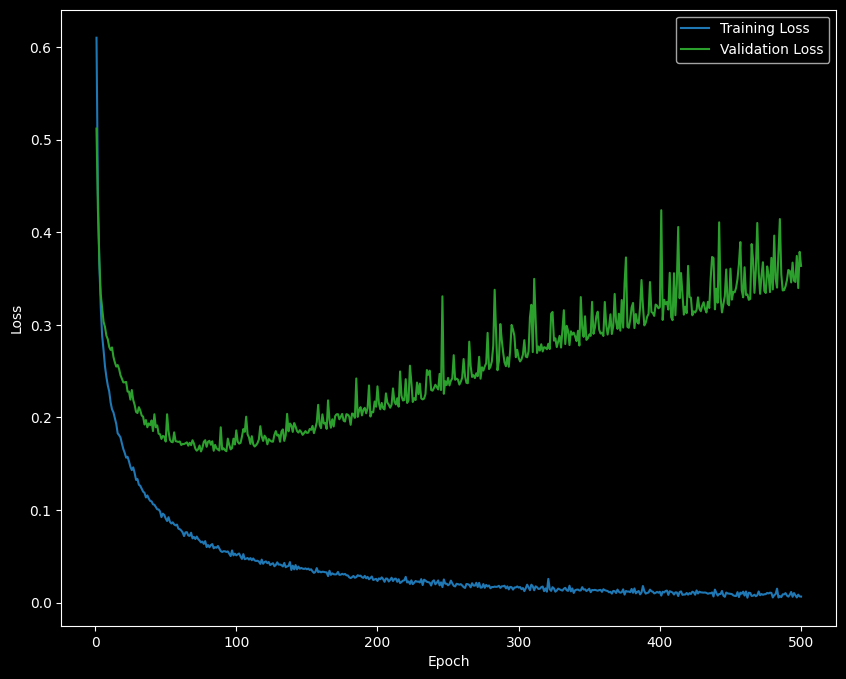

In [ ]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

In [ ]:
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

9/9 [==============================] - 0s 2ms/step
[[9.9777240e-01 1.9547851e-11 7.3755216e-15 2.2276267e-03]
 [4.1349567e-06 4.6823770e-02 9.5086604e-01 2.3060353e-03]
 [2.5112478e-03 6.0865341e-04 2.4373770e-04 9.9663639e-01]
 ...
 [1.2401455e-08 2.2496179e-02 9.7740901e-01 9.4827366e-05]
 [2.2625515e-12 3.3748433e-01 6.6251433e-01 1.3415907e-06]
 [9.9994147e-01 2.7607417e-12 5.2614047e-17 5.8533573e-05]]


In [ ]:
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [ ]:
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]


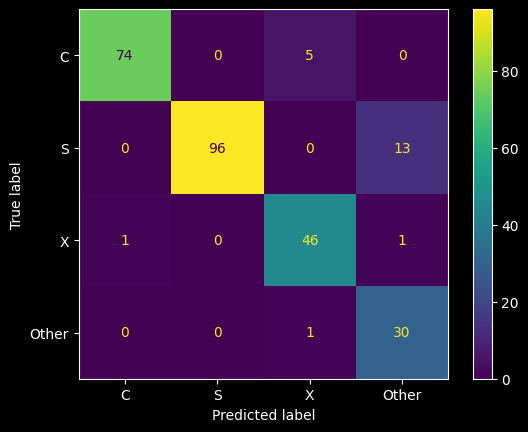

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [ ]:
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.925
